In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
trans = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.5), (0.5))
])

dataset = torchvision.datasets.FashionMNIST('.data/', download=True, train=True, transform=trans)

100%|██████████| 26421880/26421880 [00:01<00:00, 13382117.55it/s]


Extracting .data/FashionMNIST/raw/train-images-idx3-ubyte.gz to .data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211302.74it/s]


Extracting .data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to .data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3911811.72it/s]


Extracting .data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to .data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5709221.84it/s]

Extracting .data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to .data/FashionMNIST/raw



In [ ]:
dataset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
classes = list(dataset.class_to_idx.keys())

In [ ]:
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

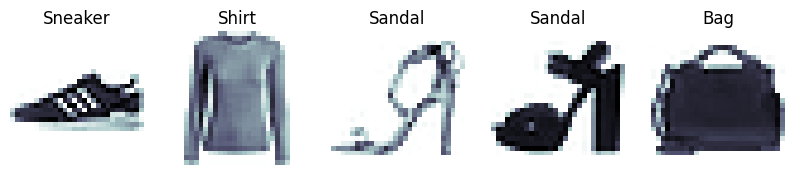

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(10,2))

for ax in axes.ravel():
  r = next(iter(dataloader))
  ax.imshow(r[0].numpy()[1].reshape(28,28), cmap='bone_r')
  ax.set_title(classes[r[1].numpy()[1]])
  ax.axis('off')


In [ ]:
class VAE(nn.Module):
  def __init__(self):
    super().__init__()

    self.input_layer = nn.Linear(784, 400)

    self.mu = nn.Linear(400, 20)

    self.sigma = nn.Linear(400, 20)

    self.upscale_sample = nn.Linear(20,400)

    self.output_layer = nn.Linear(400, 784)

  def encode(self, x):
    x = F.relu(self.input_layer(x))
    return self.mu(x), self.sigma(x)

  def parametric(self, mu, sigma):
    std = sigma.exp()

    if torch.cuda.is_available():
      sample = torch.cuda.FloatTensor(mu.size()).normal_()
    else:
      sample = torch.FloatTensor(mu.size()).normal_()

    sample = Variable(sample)

    return sample.mul(std).add(mu)

  def decode(self, sample):
    x = F.relu(self.upscale_sample(sample))
    return torch.sigmoid(self.output_layer(x))


  def forward(self, x):
    mu, sigma = self.encode(x)
    sample = self.parametric(mu, sigma)

    return self.decode(sample), mu, sigma

In [ ]:
model = VAE().to(device)

In [ ]:
model

VAE(
  (input_layer): Linear(in_features=784, out_features=400, bias=True)
  (mu): Linear(in_features=400, out_features=20, bias=True)
  (sigma): Linear(in_features=400, out_features=20, bias=True)
  (upscale_sample): Linear(in_features=20, out_features=400, bias=True)
  (output_layer): Linear(in_features=400, out_features=784, bias=True)
)

In [ ]:
def loss_function(reconstructed, real, mu, sigma):
  image_loss = nn.MSELoss(reduction='sum')(reconstructed, real)

  kl_loss = -0.5*(torch.sum(1+sigma - mu.pow(2) - sigma.exp()))

  return image_loss, kl_loss

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
epochs = 10

for epoch in range(epochs):
  model.train()

  print(f"Epoch: {epoch}")

  train_loss_im, train_loss_kl = 0,0

  for b, data in enumerate(dataloader):
    img, _ = data

    img = img.view(img.size(0), -1)
    img = Variable(img).to(device)

    optimizer.zero_grad()

    recons, mu, sigma = model(img)

    loss_im, loss_kl = loss_function(recons, img, mu, sigma)

    loss = loss_im+loss_kl

    loss.backward()
    optimizer.step()




Epoch: 0


<ipython-input-8-35dae9c17d9a>:23: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  sample = torch.cuda.FloatTensor(mu.size()).normal_()


Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


[]

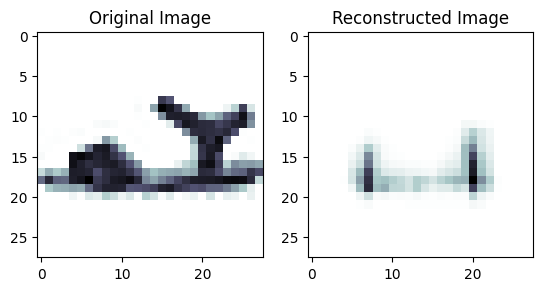

In [ ]:
model.eval()

ev_img = next(iter(dataloader))[0].numpy()[1].reshape(28,28)

ev_img_r = ev_img.ravel()

ev_mu, ev_sigma = model.encode(torch.from_numpy(ev_img_r).cuda())

ev_param_tensor = model.parametric(ev_mu, ev_sigma)

ev_out = model.decode(ev_param_tensor).cpu().detach().numpy().reshape(28,28)

fig, ax = plt.subplots(1,2)

ax[0].set_title('Original Image')

ax[0].imshow(ev_img, cmap='bone_r')

ax[1].set_title('Reconstructed Image')

ax[1].imshow(ev_out, cmap='bone_r')

plt.plot()